<a href="https://colab.research.google.com/github/KenzaBnc/KenzaBnc/blob/main/Pipeline_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ====== **PIPELINE STRUCTUREL A2A** ======

### **Auteurs** : Kenza BENACHENHOU - Hyacinthe HLANNON - Nguessan NGBAIN - M1 Bioinformatique et Biologie des Systèmes

### **Objectif** : Recherche de structures A2A, extraction de ligands, analyse structurale, visualisation PyMOL



---


======= MODULES IMPORTÉS =======

In [2]:
!pip install MDAnalysis
!pip install biopython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.7/108.7 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 87.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 73.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 29.4 MB/s eta 0:00:00


In [3]:
import os
import re
import time
import glob
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import MDAnalysis as mda
from Bio.PDB import PDBList, PDBParser, MMCIFParser
from scipy.stats import chi2_contingency

 ====== PARAMÈTRES GLOBAUX ======


In [4]:
SEUILS_IDENTITE = [0.3, 0.4, 0.5, 0.6, 0.7]
SEUIL_CONTACT = 5.0 #Angstroms
SEUIL_CONSENSUS = 0.4 #40%
RECEPTEUR_SEQ = "MPIMGSSVYITVELAIAVLAILGNVLVCWAVWLNSNLQNVTNYFVVSLAAADIAVGVLAIPFAITISTGFCAACHGCLFIACFVLVLTQSSIFSLLAIAIDRYIAIRIPLRYNGLVTGTRAKGIIAICWVLSFAIGLTPMLGWNNCGQPKEGKNHSQGCGEGQVACLFEDVVPMNYMVYFNFFACVLVPLLLMLGVYLRIFLAARRQLKQMESQPLPGERARSTLQKEVHAAKSLAIIVGLFALCWLPLHIINCFTFFCPDCSHAPLWLMYLAIVLSHTNSVVNPFIYAYRIREFRQTFRKIIRSHVLRQQEPFKAAGTSARVLAAHGSDGEQVSLRLNGHPPGVWANGSAPHPERRPNGYALGLVSGGSAQESQGNTGLPDVELLSHELKGVCPEPPGLDDPLAQDGAGVS"
#Séquence du récepteur A2A


====== CATEGORISATION PAR MOTS-CLÉS ======

In [5]:
categorie_mots_cles = [
    ("Nucleotide", ["adenosine", "guanosine", "cytidine", "uridine", "gmp", "atp", "utp", "ctp", "amp", "nucleotide", "purine", "pyrimidine"]),
    ("Peptide", ["peptide", "dipeptide", "oligopeptide", "polypeptide", "biocytin", "glutathione", "amide-bonded", "lysyl", "glutamyl", "tripeptide", "tetrapeptide", "pentapeptide", "hexapeptide", "acetylated peptide", "linear peptide", "bonded peptide"]),
    ("Amine", ["caffeine", "azanyl", "amine", "amino", "guanidine", "imidazole", "nh2", "thiazol"]),
    ("Agoniste", ["agonist", "agoniste", "activator", "stimulator"]),
    ("Antagoniste", ["antagonist", "antagoniste", "blocker", "zm241385", "istradefylline", "zm2"]),
    ("Inhibiteur", ["inhibitor", "inhibiteur"]),
    ("Sucre", ["glucose", "fructose", "sugar", "ose", "saccharide", "malto"]),
    ("Aromatique", ["benz", "phenyl", "aromatic", "pyrid", "indole", "quinoline"]),
    ("Alcool", ["ethanol", "propanol", "butanol", "methanol", "alcohol", "glycerol"]),
    ("Ion", ["sodium", "potassium", "chloride", "na+", "k+", "cl-", "ca2+", "zn2+", "mg2+", "cu2+"]),
    ("Solvant", ["detergent", "solvent", "triton", "digitonin"]),
    ("Colorant", ["fluorescent", "dye", "fluorophore", "rhodamine", "fluorescein"]),
    ("Triazole", ["triazole", "triazol", "triazine"]),
    ("Acide", ["carboxy", "acid", "acetate", "oic", "carboxylate"]),
    ("Cyane", ["cyano", "cyan"]),
    ("Autre", ["compound", "substrate", "analog"])
]

====== FONCTIONS DÉFINIES ======

In [6]:
# === Fonction 1 : Recherche des structures PDB par seuil d'identité ===

def search_pdb_by_sequence(sequence, identity):
    url = "https://search.rcsb.org/rcsbsearch/v2/query"
    query = {
        "query": {
            "type": "group",
            "logical_operator": "and",
            "nodes": [{
                "type": "terminal",
                "service": "sequence",
                "parameters": {
                    "evalue_cutoff": 1e-5,
                    "identity_cutoff": identity,
                    "sequence_type": "protein",
                    "value": sequence
                }
            }]
        },
        "request_options": {"paginate": {"start": 0, "rows": 200}},
        "return_type": "entry"
    }
    try:
        response = requests.post(url, json=query, timeout=15)
        response.raise_for_status()
        data = response.json()
        return list(set(d['identifier'] for d in data.get('result_set', [])))
    except Exception as e:
        print(f"[Erreur API RCSB] {e}")
        return []

In [7]:
# === Fonction 2 : Classification des protéines A2A vs autres ===

def classify_pdb_ids(pdb_ids):
    a2a, others = [], []
    for pdb in pdb_ids:
        try:
            time.sleep(1)
            html = requests.get(f"https://www.rcsb.org/structure/{pdb}", timeout=10).text.lower()
            if "a2a" in html and ("ligand" in html or "complex" in html):
                a2a.append(pdb)
            else:
                others.append(pdb)
        except:
            continue
    return a2a, others

In [9]:
# === Fonction 3 : Extraction des ligands via fichiers CIF (en mémoire) ===

def extract_ligands_from_cif(pdb_ids):
    ligands = set()
    exclusions = {"HOH", "DOD", "SO4", "NA", "CL", "K", "MG", "CA", "ZN", "MN", "CU", "FE",
                  "SOG", "CLR", "OLB", "GDP", "NA", "OLC", "OLA", "TAR", "STE", "LMT", "PEG", "EDT"}

    # Motifs parasites fréquents dans les noms des résidus extraits à tort
    motifs_parasites = ["peptide linking", "l-peptide linking", "linking' y"]

    # Acides aminés classiques qu'on veut détecter dans les résidus
    aa_terms = ["glycine", "alanine", "valine", "leucine", "isoleucine", "serine", "threonine",
                "cysteine", "methionine", "phenylalanine", "tyrosine", "tryptophan", "aspartic",
                "glutamic", "asparagine", "glutamine", "lysine", "arginine", "histidine",
                "proline", "asp", "glu", "asn", "gln", "lys", "arg", "his", "pro", "gly",
                "val", "ile", "thr", "ser", "cys", "met", "phe", "trp", "tyr"]

    for pdb_id in pdb_ids:
        try:
            time.sleep(1)
            url = f"https://files.rcsb.org/download/{pdb_id}.cif"
            response = requests.get(url, timeout=10)
            response.raise_for_status()
            content = response.text
            comp_blocks = re.findall(r"_chem_comp.id\s+(\w+)\s+_chem_comp.name\s+'([^']+)'", content)
            if not comp_blocks:
                inside_block = False
                lines = content.splitlines()
                header_indices = {}
                data_start = None
                for i, line in enumerate(lines):
                    if line.strip() == "loop_":
                        inside_block = False
                    elif "_chem_comp.id" in line:
                        inside_block = True
                        header_indices['id'] = len(header_indices)
                    elif "_chem_comp.name" in line:
                        header_indices['name'] = len(header_indices)
                    elif inside_block and line.strip() and not line.startswith("_"):
                        data_start = i
                        break
                if data_start is not None:
                    for line in lines[data_start:]:
                        if not line.strip() or line.startswith("_") or line.startswith("loop_"):
                            break
                        parts = line.strip().split(None, maxsplit=max(header_indices.values()))
                        if len(parts) > max(header_indices.values()):
                            comp_id = parts[header_indices['id']].strip().upper()
                            name = parts[header_indices['name']].strip().lower()
                            comp_blocks.append((comp_id, name))
            for comp_id, name in comp_blocks:
                comp_id = comp_id.upper()
                name = name.strip().lower()
                if comp_id in exclusions:
                    continue
                if any(motif in name for motif in motifs_parasites):
                    continue
                if re.search(r"y\s+(" + "|".join(aa_terms) + ")", name):
                    continue
                ligands.add((pdb_id.upper(), name, comp_id.lower()))
        except Exception as e:
            print(f"[Erreur parsing {pdb_id}] {e}")
            continue
    return list(ligands)

In [10]:
# === Fonction 4 : Classification automatique par mots-clés ===

def classer_ligand_par_mots(nom, lig_id=None):
    nom = nom.lower()
    lig_id = lig_id.lower() if lig_id else ""
    for cat, mots in categorie_mots_cles:
        if any(m in nom for m in mots):
            return cat
    return "Inconnu"

In [11]:
# === ÉTAPE SUPPLÉMENTAIRE : STRUCTURES PAR CATÉGORIE ===
def export_structures_par_categorie(input_csv="ligands_classifies_cif.csv"):
    df = pd.read_csv(input_csv)
    df = df[df["Categorie"].isin(["Amine", "Nucleotide"])]
    df = df.drop_duplicates(subset=["Structure", "ID", "Nom", "Categorie"])
    df = df.sort_values(by="Structure")
    df.to_csv("ligands_amines_nucleotides.csv", index=False)

    ligand_df = df.copy()
    pivot_df = ligand_df.pivot_table(index="Structure", columns="Categorie", aggfunc="size", fill_value=0)

    structures_nucleotides = pivot_df[pivot_df.get("Nucleotide", 0) > 0].index.tolist()
    structures_amines = pivot_df[pivot_df.get("Amine", 0) > 0].index.tolist()
    structures_mix = pivot_df[(pivot_df.get("Nucleotide", 0) > 0) & (pivot_df.get("Amine", 0) > 0)].index.tolist()

    pd.DataFrame({"PDB_ID": structures_nucleotides}).to_csv("structures_nucleotides.csv", index=False)
    pd.DataFrame({"PDB_ID": structures_amines}).to_csv("structures_amines.csv", index=False)
    pd.DataFrame({"PDB_ID": structures_mix}).to_csv("structures_mix.csv", index=False)

    print("✅ Exports générés : structures_nucleotides.csv, structures_amines.csv, structures_mix.csv")

====== MAIN PIPELINE (PARTIE 1) ======

In [24]:
def main():
    ligands_totaux = set()
    for seuil in SEUILS_IDENTITE:
        print(f"\n🔍 Seuil {seuil}")
        pdb_ids = search_pdb_by_sequence(RECEPTEUR_SEQ, seuil)
        print(f"→ {len(pdb_ids)} structures récupérées")
        a2a_pdbs, _ = classify_pdb_ids(pdb_ids)
        print(f"✅ {len(a2a_pdbs)} identifiées comme A2A")
        ligands = extract_ligands_from_cif(a2a_pdbs)
        print(f"♦ {len(ligands)} ligands extraits")
        ligands_totaux.update(ligands)

    ligand_data = [{
        "Structure": pdb_id,
        "ID": lig_id.upper(),
        "Nom": name.title(),
        "Categorie": classer_ligand_par_mots(name, lig_id)
    } for (pdb_id, name, lig_id) in ligands_totaux]

    ligand_df = pd.DataFrame(ligand_data)
    ligand_df.to_csv("ligands_classifies_cif.csv", index=False)
    print("✅ Export CSV : ligands_classifies_cif.csv")


In [13]:
def filtrer_et_exporter_par_categorie(fichier_csv="ligands_classifies_cif.csv"):
    df = pd.read_csv(fichier_csv)
    df["Nom"] = df["Nom"].astype(str).str.strip("'").str.strip().str.lower()
    df["ID"] = df["ID"].astype(str).str.strip().str.upper()

    categories_cibles = ["Peptide", "Nucleotide", "Amine"]
    ligands_filtres = df[df["Categorie"].isin(categories_cibles)]

    tableau_croise = ligands_filtres.groupby(["Structure", "Categorie"])["ID"].nunique().unstack(fill_value=0).reset_index()
    tableau_croise.to_csv("ligands_par_structure_et_categorie.csv", index=False)
    print("✅ Export : ligands_par_structure_et_categorie.csv")


In [14]:
def export_structures_par_categorie(input_csv="ligands_classifies_cif.csv"):
    df = pd.read_csv(input_csv)
    df = df[df["Categorie"].isin(["Amine", "Nucleotide"])]
    df = df.drop_duplicates(subset=["Structure", "ID", "Nom", "Categorie"])
    df = df.sort_values(by="Structure")
    df.to_csv("ligands_amines_nucleotides.csv", index=False)

    ligand_df = df.copy()
    pivot_df = ligand_df.pivot_table(index="Structure", columns="Categorie", aggfunc="size", fill_value=0)

    structures_nucleotides = pivot_df[pivot_df.get("Nucleotide", 0) > 0].index.tolist()
    structures_amines = pivot_df[pivot_df.get("Amine", 0) > 0].index.tolist()
    structures_mix = pivot_df[(pivot_df.get("Nucleotide", 0) > 0) & (pivot_df.get("Amine", 0) > 0)].index.tolist()

    pd.DataFrame({"PDB_ID": structures_nucleotides}).to_csv("structures_nucleotides.csv", index=False)
    pd.DataFrame({"PDB_ID": structures_amines}).to_csv("structures_amines.csv", index=False)
    pd.DataFrame({"PDB_ID": structures_mix}).to_csv("structures_mix.csv", index=False)

    print("✅ Exports générés : structures_nucleotides.csv, structures_amines.csv, structures_mix.csv")


In [15]:
def export_structure_ligand_unique(input_csv="ligands_classifies_cif.csv"):
    df = pd.read_csv(input_csv)
    df = df[df["Categorie"].isin(["Amine", "Nucleotide"])]
    df = df.drop_duplicates(subset=["Structure", "ID", "Categorie"])
    df = df[["Structure", "ID", "Categorie"]].rename(columns={
        "Structure": "PDB_ID",
        "ID": "Ligand_ID",
        "Categorie": "Categorie"
    })
    df.to_csv("structure_ligand_principal.csv", index=False)
    print("✅ Export : structure_ligand_principal.csv")

In [16]:
def extraire_coordonnees_resid_chainid(input_csv="structure_ligand_principal.csv"):
    from Bio.PDB import PDBList, PDBParser
    df = pd.read_csv(input_csv)
    pdbl = PDBList()
    parser = PDBParser(QUIET=True)

    residues = []
    chains = []
    os.makedirs("pdb_files", exist_ok=True)

    for i, row in df.iterrows():
        pdb_id = row["PDB_ID"].lower()
        lig_id = row["Ligand_ID"].upper()

        try:
            pdb_file = pdbl.retrieve_pdb_file(pdb_id, file_format="pdb", pdir="./pdb_files", overwrite=True)
            structure = parser.get_structure(pdb_id, pdb_file)
            best_residue = None
            max_atoms = 0
            for model in structure:
                for chain in model:
                    for residue in chain:
                        hetfield = residue.get_id()[0]
                        resname = residue.get_resname().strip().upper()
                        if hetfield.startswith("H_") and resname == lig_id:
                            atom_count = len([a for a in residue])
                            if atom_count > max_atoms:
                                max_atoms = atom_count
                                best_residue = residue
            if best_residue:
                residues.append(best_residue.get_id()[1])
                chains.append(best_residue.get_parent().id)
            else:
                print(f"[❗] Ligand {lig_id} non trouvé dans {pdb_id.upper()}")
                residues.append(None)
                chains.append(None)
        except Exception as e:
            print(f"[Erreur] {pdb_id.upper()} : {e}")
            residues.append(None)
            chains.append(None)

    df["ResID"] = residues
    df["ChainID"] = chains
    df.to_csv("structure_ligand_principal_with_chainid.csv", index=False)
    print("✅ Fichier généré : structure_ligand_principal_with_chainid.csv")


In [17]:
def corriger_coordonnees_manquantes(input_csv="structure_ligand_principal_with_chainid.csv"):
    df = pd.read_csv(input_csv)
    df_to_fix = df[df["ResID"].isna() | df["ChainID"].isna()].copy()
    exclusions = {"HOH", "DOD", "SO4", "NA", "CL", "K", "MG", "CA", "ZN", "MN", "CU", "FE", "SOG", "CLR", "OLB", "GDP", "OLC", "OLA", "TAR", "STE", "LMT", "PEG", "EDO", "TRS", "GOL", "EDT"}
    pdbl = PDBList()
    parser = MMCIFParser(QUIET=True)
    resids, chains, ligand_ids = [], [], []
    for _, row in df_to_fix.iterrows():
        pdb_id = row["PDB_ID"].lower()
        try:
            cif_file = pdbl.retrieve_pdb_file(pdb_id, file_format="mmCif", pdir="./cif_files", overwrite=True)
            structure = parser.get_structure(pdb_id, cif_file)
            best_residue, max_atoms, best_resname = None, 0, None
            for model in structure:
                for chain in model:
                    for residue in chain:
                        hetfield = residue.id[0]
                        resname = residue.resname.strip().upper()
                        if hetfield.startswith("H_") and resname not in exclusions:
                            n_atoms = len([a for a in residue])
                            if n_atoms > max_atoms:
                                max_atoms = n_atoms
                                best_residue = residue
                                best_resname = resname
            if best_residue:
                resids.append(best_residue.id[1])
                chains.append(best_residue.get_parent().id)
                ligand_ids.append(best_resname)
            else:
                print(f"[❗] Aucun ligand valide détecté dans {pdb_id.upper()}")
                resids.append(None)
                chains.append(None)
                ligand_ids.append(None)
        except Exception as e:
            print(f"[Erreur] {pdb_id.upper()} : {e}")
            resids.append(None)
            chains.append(None)
            ligand_ids.append(None)
    df_to_fix["ResID"] = resids
    df_to_fix["ChainID"] = chains
    df_to_fix["Ligand_ID"] = ligand_ids
    df_ok = df.dropna(subset=["ResID", "ChainID"])
    df_final = pd.concat([df_ok, df_to_fix], ignore_index=True)
    df_final.to_csv("structure_ligand_principal_corrected_final.csv", index=False)
    print("✅ Fichier corrigé généré : structure_ligand_principal_corrected_final.csv")


In [18]:
def generer_scripts_superposition():
    # Chargement du fichier avec ResID et ChainID
    df_ligands = pd.read_csv("structure_ligand_principal_corrected_final.csv")

    # Fichiers par catégorie
    categories = {
        "amines": "structures_amines.csv",
        "nucleotides": "structures_nucleotides.csv",
        "mix": "structures_mix.csv"
    }

    # Distance de contact
    distance_cutoff = 5

    for cat, csv_file in categories.items():
        df_structures = pd.read_csv(csv_file)
        pdb_ids = df_structures["PDB_ID"].dropna().unique()
        if len(pdb_ids) == 0:
            continue

        script_path = f"superposition_{cat}_with_contacts.pml"

        with open(script_path, "w") as f:
            f.write("reinitialize\n")
            f.write("bg_color white\n")
            f.write("set auto_zoom, off\n")

            # Structure de référence
            ref_id = pdb_ids[0]
            try:
                ref_row = df_ligands[df_ligands["PDB_ID"] == ref_id].iloc[0]
                ref_lig = ref_row["Ligand_ID"]
                ref_resi = int(ref_row["ResID"])
                ref_chain = ref_row["ChainID"]

                f.write(f"fetch {ref_id}, async=0\n")
                f.write(f"set_name {ref_id}, ref_{cat}\n")
                f.write(f"hide everything, ref_{cat}\n")
                f.write(f"show cartoon, ref_{cat}\n")
                f.write(f"color green, ref_{cat}\n")
                f.write(f"select ligand_main, ref_{cat} and resn {ref_lig.upper()} and resi {ref_resi} and chain {ref_chain}\n")
                f.write(f"show sticks, ligand_main\n")
                f.write(f"color red, ligand_main\n\n")
            except IndexError:
                print(f"⚠️ Skipped] Pas de correspondance ligand pour structure de référence {ref_id}")
                continue

            # Ajout des structures supplémentaires
            for i, pdb_id in enumerate(pdb_ids[1:], start=1):
                try:
                    lig_row = df_ligands[df_ligands["PDB_ID"] == pdb_id].iloc[0]
                    lig_id = lig_row["Ligand_ID"]
                    lig_resi = int(lig_row["ResID"])
                    lig_chain = lig_row["ChainID"]
                except IndexError:
                    print(f"⚠️ Skipped] Pas de correspondance ligand pour {pdb_id}")
                    continue

                obj = f"mobile_{cat}_{i}"
                f.write(f"fetch {pdb_id}, async=0\n")
                f.write(f"set_name {pdb_id}, {obj}\n")
                f.write(f"align {obj}, ref_{cat}\n")
                f.write(f"hide everything, {obj}\n")
                f.write(f"show cartoon, {obj}\n")
                f.write(f"color tv_orange, {obj}\n")
                f.write(f"select ligand_{i}, {obj} and resn {lig_id.upper()} and resi {lig_resi} and chain {lig_chain}\n")
                f.write(f"show sticks, ligand_{i}\n")
                f.write(f"color red, ligand_{i}\n\n")

            # Résidus en contact
            f.write(f"select residues_contact_{cat}, byres (ref_{cat} within {distance_cutoff} of ligand_main and not resn HOH)\n")
            f.write(f"show sticks, residues_contact_{cat}\n")
            f.write(f"color cyan, residues_contact_{cat}\n")
            f.write(f"zoom residues_contact_{cat}\n")
            f.write(f"label residues_contact_{cat} and name CA, \"%s-%s\" % (resn,resi)\n\n")

            # Sauvegarde PDB
            f.write("set retain_order, 1\n")
            f.write(f"save contacts_{cat}.pdb, residues_contact_{cat}, format=pdb\n")

        print(f"✅ Script généré : {script_path}")


In [19]:
def extraire_residus_contacts():
    parser = PDBParser(QUIET=True)
    for cat in ["amines", "nucleotides"]:
        pdb_file = f"contacts_{cat}.pdb"
        if not os.path.exists(pdb_file):
            print(f"Fichier manquant : {pdb_file}")
            continue
        structure = parser.get_structure(cat, pdb_file)
        records = []
        for model in structure:
            for chain in model:
                for residue in chain:
                    if "CA" in residue:
                        resname = residue.get_resname()
                        resnum = residue.get_id()[1]
                        chain_id = chain.id
                        records.append((resname, resnum, chain_id))
        df = pd.DataFrame(records, columns=["ResName", "ResID", "Chain"])
        df.to_csv(f"contacts_{cat}.csv", index=False)
        print(f"Fichier CSV généré : contacts_{cat}.csv")

In [20]:
def analyser_contacts_par_categorie():
    categories = ["amines", "nucleotides"]
    dfs = []
    for cat in categories:
        df = pd.read_csv(f"contacts_{cat}.csv")
        df["Catégorie"] = cat.capitalize()
        dfs.append(df)
    df_all = pd.concat(dfs, ignore_index=True)
    tableau = pd.crosstab(df_all["Catégorie"], df_all["ResName"])
    print("Tableau croisé Catégorie × Résidu :")
    print(tableau)
    chi2, p, dof, expected = chi2_contingency(tableau)
    print("Test du Chi² :")
    print(f"Chi² statistic = {chi2:.2f}")
    print(f"Degrees of freedom = {dof}")
    print(f"P-value = {p:.4e}")
    if p < 0.05:
        print("Résultat : Il existe une dépendance significative entre la catégorie du ligand et les résidus de contact.")
    else:
        print("Résultat : Aucune dépendance significative détectée entre la catégorie du ligand et les résidus de contact.")

In [25]:
if __name__ == "__main__":
    main()
    filtrer_et_exporter_par_categorie()
    export_structures_par_categorie()
    export_structure_ligand_unique()
    extraire_coordonnees_resid_chainid()
    corriger_coordonnees_manquantes()
    generer_scripts_superposition()
    print("Exécuter les scripts PML dans PyMOL pour générer les fichiers PDB (contacts_*.pdb).")



🔍 Seuil 0.3
→ 200 structures récupérées
✅ 98 identifiées comme A2A
♦ 1310 ligands extraits

🔍 Seuil 0.4
→ 112 structures récupérées
✅ 95 identifiées comme A2A
♦ 1296 ligands extraits

🔍 Seuil 0.5
→ 102 structures récupérées
✅ 95 identifiées comme A2A
♦ 1296 ligands extraits

🔍 Seuil 0.6
→ 94 structures récupérées
✅ 94 identifiées comme A2A
♦ 1273 ligands extraits

🔍 Seuil 0.7
→ 88 structures récupérées
✅ 88 identifiées comme A2A
♦ 1249 ligands extraits
✅ Export CSV : ligands_classifies_cif.csv
✅ Export : ligands_par_structure_et_categorie.csv
✅ Exports générés : structures_nucleotides.csv, structures_amines.csv, structures_mix.csv
✅ Export : structure_ligand_principal.csv
[❗] Ligand ;2-[P-(2-CARBOXYETHYL)PHENYLETHYL-AMINO]-5'-N-ETHYLCARBOXAMIDO non trouvé dans 4UG2
[❗] Ligand ;2-[P-(2-CARBOXYETHYL)PHENYLETHYL-AMINO]-5'-N-ETHYLCARBOXAMIDO non trouvé dans 4UHR
Desired structure doesn't exist
[Erreur] 8RW4 : [Errno 2] No such file or directory: './pdb_files/pdb8rw4.ent'
[❗] Ligand ;~{TER

In [26]:
    extraire_residus_contacts()
    analyser_contacts_par_categorie()

Fichier CSV généré : contacts_amines.csv
Fichier CSV généré : contacts_nucleotides.csv
Tableau croisé Catégorie × Résidu :
ResName      ALA  ASN  GLU  HIS  ILE  LEU  MET  PHE  SER  THR  TRP  TYR  VAL
Catégorie                                                                   
Amines         1    2    1    2    1    3    2    1    0    0    1    1    0
Nucleotides    1    2    1    2    1    2    2    1    1    1    1    0    1
Test du Chi² :
Chi² statistic = 4.17
Degrees of freedom = 12
P-value = 9.8013e-01
Résultat : Aucune dépendance significative détectée entre la catégorie du ligand et les résidus de contact.


# **II. PARTIE 2 : ANALYSE STRUCTURALE ET VISUALISATION**

---



======= II - 0.MODULES IMPORTÉS =======


In [27]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import MDAnalysis as mda

 ====== II - 1.PARAMÈTRES GLOBAUX ======


In [28]:
CUTOFF = 5.0
SEUIL_SPECIFIQUE = 40
COMPLEX_DIR = "pdb_files"
CSV_LIGANDS = "structure_ligand_principal_corrected_final.csv"
FREQ_LABEL = 90
#Afficher les labels dans pyMOL pour les résidus A2A contactés par au moins 90% des ligands

In [29]:
# === Renommer les fichiers `.ent` en `.pdb` ===
for fname in os.listdir(COMPLEX_DIR):
    if fname.endswith(".ent") and fname.startswith("pdb"):
        pdb_id = fname[3:-4]
        new_name = f"A2A_{pdb_id}.pdb"
        os.rename(os.path.join(COMPLEX_DIR, fname), os.path.join(COMPLEX_DIR, new_name))

print("✅ Tous les fichiers ont été renommés au format A2A_<id>.pdb")

✅ Tous les fichiers ont été renommés au format A2A_<id>.pdb


====== II - 2. CHARGEMENT DES DONNEES LIGAND - STRUCTURE ======

In [30]:
ligands_df = pd.read_csv(CSV_LIGANDS)
ligands_df["PDB_ID"] = ligands_df["PDB_ID"].str.upper().str.strip()
ligands_df["Ligand_ID"] = ligands_df["Ligand_ID"].str.upper().str.strip()
ligands_df["ChainID"] = ligands_df["ChainID"].astype(str).str.strip()
ligands_df["ResID"] = ligands_df["ResID"].astype(float).astype(int)

pdb_files = sorted([os.path.join(COMPLEX_DIR, f) for f in os.listdir(COMPLEX_DIR) if f.endswith(".pdb")])

====== II - 3.EXTRACTION DES DISTANCES (2 étapes) ======

Création de deux matrices de distance (minimale et moyenne)

In [31]:
def extract_pdb_id(pdb_filename):
    return os.path.basename(pdb_filename).replace(".pdb", "").split("_")[1].upper()

ligand_names, all_residues = [], set()

# Étape 1 : collecter tous les résidus contactés
for pdb_path in pdb_files:
    pdb_id = extract_pdb_id(pdb_path)
    ligand_row = ligands_df[ligands_df["PDB_ID"] == pdb_id]
    if ligand_row.empty: continue
    ligand_row = ligand_row.iloc[0]
    ligand_id, resid, chain = ligand_row["Ligand_ID"], int(ligand_row["ResID"]), ligand_row["ChainID"]
    try:
        u = mda.Universe(pdb_path)
        ligand = u.select_atoms(f"resname {ligand_id} and resid {resid} and segid {chain}")
        if len(ligand) == 0: continue
        prot = u.select_atoms("protein")
        for res in prot.residues:
            dists = np.linalg.norm(res.atoms.positions[:, None] - ligand.positions, axis=2)
            if np.any(dists <= CUTOFF):
                all_residues.add((res.resname, res.resid))
        ligand_names.append(f"{pdb_id}_{ligand_id}")
    except:
        continue

res_labels = [f"{r[0]}-{r[1]}" for r in sorted(all_residues, key=lambda x: x[1])]
min_matrix, mean_matrix = [], []

# Étape 2 : calculer les distances
for pdb_path in pdb_files:
    pdb_id = extract_pdb_id(pdb_path)
    ligand_row = ligands_df[ligands_df["PDB_ID"] == pdb_id]
    if ligand_row.empty: continue
    ligand_row = ligand_row.iloc[0]
    ligand_id, resid, chain = ligand_row["Ligand_ID"], int(ligand_row["ResID"]), ligand_row["ChainID"]
    try:
        u = mda.Universe(pdb_path)
        ligand = u.select_atoms(f"resname {ligand_id} and resid {resid} and segid {chain}")
        if len(ligand) == 0: continue
        prot = u.select_atoms("protein")
        min_row, mean_row = [], []
        for resn, resi in sorted(all_residues, key=lambda x: x[1]):
            atoms = prot.select_atoms(f"resname {resn} and resid {resi}")
            if len(atoms) == 0:
                min_row.append(np.nan)
                mean_row.append(np.nan)
            else:
                dists = np.linalg.norm(atoms.positions[:, None] - ligand.positions, axis=2)
                min_row.append(np.min(dists))
                mean_row.append(np.mean(dists))
        min_matrix.append(min_row)
        mean_matrix.append(mean_row)
    except:
        continue

df_min = pd.DataFrame(min_matrix, index=ligand_names, columns=res_labels)
df_mean = pd.DataFrame(mean_matrix, index=ligand_names, columns=res_labels)
df_min.to_csv("ligand_residue_min.csv")
df_mean.to_csv("ligand_residue_mean.csv")
print("✅ Distances min et moyennes enregistrées.")

/usr/local/lib/python3.11/dist-packages/MDAnalysis/coordinates/PDB.py:453: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to None.
  warnings.warn("1 A^3 CRYST1 record,"


✅ Distances min et moyennes enregistrées.


In [32]:
# === Ajout des catégories depuis le fichier de référence
df_meta = pd.read_csv(CSV_LIGANDS)
df_meta["Full_ID"] = df_meta["PDB_ID"].str.upper().str.strip() + "_" + df_meta["Ligand_ID"].str.upper().str.strip()
df_meta = df_meta.set_index("Full_ID")
df_min["Catégorie"] = df_min.index.map(lambda x: df_meta.loc[x, "Categorie"] if x in df_meta.index else "Inconnu")

====== II - 4.HEATMAP GLOBALE (2 colonnes) ======

In [33]:
plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
sns.heatmap(df_min.drop("Catégorie", axis=1), cmap="Blues_r", vmin=0, vmax=8)
plt.title("Distances minimales (contacts directs)")
plt.subplot(1, 2, 2)
sns.heatmap(df_mean, cmap="Reds_r", vmin=0, vmax=10)
plt.title("Distances moyennes (exposition globale)")
plt.tight_layout()
plt.savefig("heatmaps_min_mean_inverses.png", dpi=300)
plt.close()

In [34]:
df_min_clean = df_min.drop("Catégorie", axis=1).fillna(10)
df_mean_clean = df_mean.fillna(10)

plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
sns.heatmap(df_min_clean, cmap="Blues_r", vmin=0, vmax=8)
plt.title("Distances minimales (contacts directs)")
plt.subplot(1, 2, 2)
sns.heatmap(df_mean_clean, cmap="Reds_r", vmin=0, vmax=10)
plt.title("Distances moyennes (exposition globale)")
plt.tight_layout()
plt.savefig("heatmaps_min_mean_inverses.png", dpi=300)
plt.close()

====== II - 5.TOP 30 RESIDUS LES PLUS FREQUEMMENT CONTACTES ======

In [35]:
top_residues = (df_min.drop("Catégorie", axis=1) <= 5).sum(axis=0).sort_values(ascending=False).head(30).index
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
sns.heatmap(df_min[top_residues], cmap="mako", vmin=0, vmax=8)
plt.title("Top 30 – Distances minimales")
plt.subplot(1, 2, 2)
sns.heatmap(df_mean[top_residues], cmap="rocket", vmin=0, vmax=10)
plt.title("Top 30 – Distances moyennes")
plt.tight_layout()
plt.savefig("heatmap_top30_structures_inverted.png", dpi=300)
plt.close()

====== II - 6.MOYENNE DES DISTANCES PAR CATEGORIE ======

In [37]:
# Remplacer les NaN par une valeur élevée (par ex. 10.0 Å)
df_cat_filled = df_cat.fillna(10.0)

# Affichage de la heatmap
plt.figure(figsize=(18, 5))
sns.heatmap(df_cat_filled, cmap="RdYlBu", vmin=0, vmax=10)
plt.title("Distances moyennes par catégorie (0–10 Å, rouge = contact rapproché)")
plt.xlabel("Résidus")
plt.ylabel("Catégorie")
plt.tight_layout()
plt.savefig("heatmap_categorie_vs_residus.png", dpi=300)
plt.close()

NameError: name 'df_cat' is not defined

====== II - 7.BINARISATION et POURCENTAGE DE CONTACT ======

In [38]:
# === 1. Charger la matrice de distances minimales
df_min = pd.read_csv("ligand_residue_min.csv", index_col=0)


In [39]:
# === 2. Ajouter la colonne "Catégorie" depuis le fichier metadata
df_meta = pd.read_csv("structure_ligand_principal_corrected_final.csv")
df_meta["Full_ID"] = df_meta["PDB_ID"].str.upper().str.strip() + "_" + df_meta["Ligand_ID"].str.upper().str.strip()
df_meta = df_meta.set_index("Full_ID")
df_min["Catégorie"] = df_min.index.map(lambda x: df_meta.loc[x, "Categorie"] if x in df_meta.index else "Inconnu")


In [40]:
# === 3. Binarisation des distances
df_bin = (df_min.drop("Catégorie", axis=1) <= SEUIL_CONTACT).astype(int)
df_bin["Catégorie"] = df_min["Catégorie"]
df_bin.drop("Catégorie", axis=1).to_csv("ligand_residue_binary.csv")
print("✅ ligand_residue_binary.csv sauvegardé")


✅ ligand_residue_binary.csv sauvegardé


In [41]:
# === 4. Calcul des pourcentages par catégorie
residus = df_bin.columns.drop("Catégorie")
table_pct = pd.DataFrame(index=residus)

for cat in ["Amine", "Nucleotide"]:
    sous_df = df_bin[df_bin["Catégorie"].str.lower() == cat.lower()].drop("Catégorie", axis=1)
    if not sous_df.empty:
        table_pct[cat] = sous_df.sum(axis=0) / len(sous_df) * 100
    else:
        table_pct[cat] = 0

table_pct.to_csv("residus_pourcentages_par_categorie.csv")
print("✅ residus_pourcentages_par_categorie.csv sauvegardé")


✅ residus_pourcentages_par_categorie.csv sauvegardé


In [42]:
# === 5. Résidus spécifiques et partagés
amines = set(table_pct[table_pct["Amine"] >= SEUIL_SPECIFIQUE].index)
nucleotides = set(table_pct[table_pct["Nucleotide"] >= SEUIL_SPECIFIQUE].index)
partages = amines & nucleotides

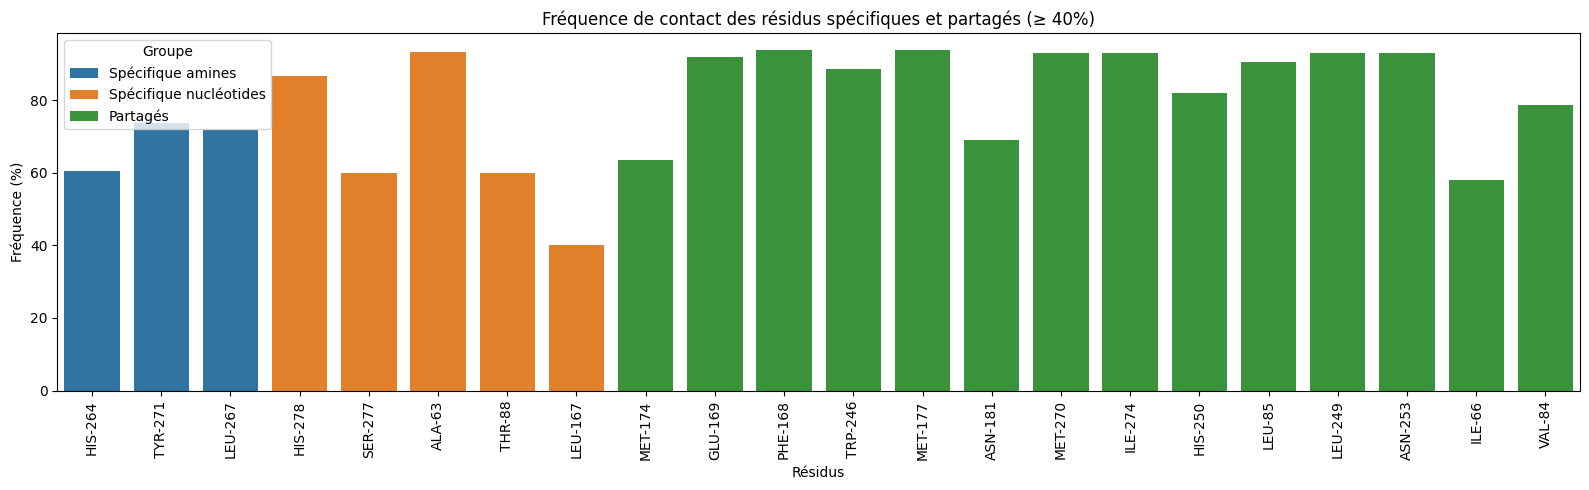

✅ Barplot enregistré


In [43]:
# === 6. Barplot
df_all = pd.concat([
    table_pct.loc[list(amines - nucleotides)].assign(Groupe="Spécifique amines", Fréquence=lambda x: x["Amine"]),
    table_pct.loc[list(nucleotides - amines)].assign(Groupe="Spécifique nucléotides", Fréquence=lambda x: x["Nucleotide"]),
    table_pct.loc[list(partages)].assign(Groupe="Partagés", Fréquence=lambda x: x[["Amine", "Nucleotide"]].mean(axis=1))
])
df_all = df_all.reset_index().rename(columns={"index": "Résidu"})

plt.figure(figsize=(16, 5))
sns.barplot(data=df_all, x="Résidu", y="Fréquence", hue="Groupe")
plt.xticks(rotation=90)
plt.title("Fréquence de contact des résidus spécifiques et partagés (≥ 40%)")
plt.ylabel("Fréquence (%)")
plt.xlabel("Résidus")
plt.tight_layout()
plt.savefig("barplot_valeurs_affichees.png", dpi=300)
plt.show()
print("✅ Barplot enregistré")

====== II - 8.RESIDUS SPECIFIQUES ======

In [44]:
amines = set(table_pct[table_pct["Amine"] >= SEUIL_SPECIFIQUE].index)
nucleotides = set(table_pct[table_pct["Nucleotide"] >= SEUIL_SPECIFIQUE].index)
partages = amines & nucleotides

====== II - 9.HEATMAP COMPARATIVE DES FREQUENCES ======

In [45]:
plt.figure(figsize=(20, 6))
sns.heatmap(table_pct.T, cmap="coolwarm")  # annot supprimé
plt.title("Comparaison des résidus en contact par catégorie")
plt.tight_layout()
plt.savefig("heatmap_frequence_contacts_categorie.png", dpi=300)
plt.close()

In [46]:
print("Amines spécifiques :", list(amines - nucleotides))
print("Nucléotides spécifiques :", list(nucleotides - amines))
print("Partagés :", list(partages))


Amines spécifiques : ['HIS-264', 'TYR-271', 'LEU-267']
Nucléotides spécifiques : ['HIS-278', 'SER-277', 'ALA-63', 'THR-88', 'LEU-167']
Partagés : ['MET-174', 'GLU-169', 'PHE-168', 'TRP-246', 'MET-177', 'ASN-181', 'MET-270', 'ILE-274', 'HIS-250', 'LEU-85', 'LEU-249', 'ASN-253', 'ILE-66', 'VAL-84']


# **III. PARTIE 3 : VISUALISATION PyMOL**

---

====== III - 1.COLORATION DES RESIDUS CONSENSUS (≥ 40% des ligands)[texte du lien

In [47]:

df_bin = pd.read_csv("ligand_residue_binary.csv", index_col=0)
nb_ligands = len(df_bin)
seuil = int(SEUIL_CONSENSUS * nb_ligands)
residus_consensus = df_bin.sum(axis=0)[lambda x: x >= seuil].index.tolist()

with open("coloration_consensus.pml", "w") as f:
    f.write("reinitialize\n")
    f.write("load A2A_peptide1.pdb, A2A\n")
    f.write("hide everything, A2A\n")
    f.write("show cartoon, A2A\n")
    f.write("color gray, A2A\n")
    for res in residus_consensus:
        resn, resid = res.split("-")
        f.write(f"color red, (A2A and resi {resid} and resn {resn})\n")

print("✅ Script PyMOL sauvegardé : coloration_consensus.pml")


✅ Script PyMOL sauvegardé : coloration_consensus.pml


====== III - 2.COLORATION DES RESIDUS CONSENSUS avec gradient fréquentiel

Value : fréquence normalisée entre 0 (rarement en contact) et 1 (résidus très fréquemment en contact). Transformation de cette valeur en une couleur (R,G,B) dans PyMOL.

bleu → résidu très rarement en contact.
violet → résidu modérement en contact
rouge → résidu très fréquemment en contact.




In [48]:
# === 8. Fichier PyMOL - gradient fréquentiel
df = table_pct.copy()
df["Moyenne"] = df[["Amine", "Nucleotide"]].mean(axis=1)
df["Norm"] = (df["Moyenne"] - df["Moyenne"].min()) / (df["Moyenne"].max() - df["Moyenne"].min())

def map_color(value):
    r = value
    g = 0.3 * (1 - value)
    b = 1 - value
    return f"[{r:.2f}, {g:.2f}, {b:.2f}]"

lines = ["reinitialize", "load A2A_peptide1.pdb, A2A", "hide everything, A2A", "show cartoon, A2A", "color gray, A2A"]
used_colors = set()

for residue, row in df.iterrows():
    if "-" not in residue: continue
    resn, resid = residue.split("-")
    norm = row["Norm"]
    cname = f"grad_{int(norm*100)}"
    if cname not in used_colors:
        lines.append(f"set_color {cname}, {map_color(norm)}")
        used_colors.add(cname)
    lines.append(f"color {cname}, (A2A and resi {resid} and resn {resn})")

with open("coloration_frequence_gradient.pml", "w") as f:
    f.write("\n".join(lines))

print("✅ coloration_frequence_gradient.pml généré")

✅ coloration_frequence_gradient.pml généré


====== III - 1.COLORATION DES RESIDUS CONSENSUS (≥ 40% des ligands)[texte du lien

In [49]:
# === 9. Fichier PyMOL - spécifique/partagés avec labels
colors = {"Amines": "deepskyblue", "Nucleotide": "forest", "Partagés": "gold"}
df_all["Groupe"] = df_all["Groupe"].replace({
    "Spécifique amines": "Amines",
    "Spécifique nucléotides": "Nucleotide"
})

lines = ["reinitialize", "load A2A_peptide1.pdb, A2A", "hide everything, A2A", "show cartoon, A2A", "color gray, A2A"]

for _, row in df_all.iterrows():
    resn, resid = row["Résidu"].split("-")
    color = colors[row["Groupe"]]
    lines.append(f"color {color}, (A2A and resi {resid} and resn {resn})")
    lines.append(f"show sticks, (A2A and resi {resid} and resn {resn})")
    if row["Fréquence"] >= FREQ_LABEL:
        lines.append(f"label (A2A and resi {resid} and resn {resn}), \"{row['Résidu']}\"")

with open("cartographie_epuree_labels.pml", "w") as f:
    f.write("\n".join(lines))

print("✅ cartographie_epuree_labels.pml généré avec labels")

✅ cartographie_epuree_labels.pml généré avec labels
